<a href="https://colab.research.google.com/github/vparonov/AIPlayground/blob/main/MagicDarts_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports and Google drive mounting 

In [1]:
import h5py
import numpy as np
import time
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Utility functions

In [3]:
def getFullPath(fileName):
  return 'drive/MyDrive/darts_data/' + fileName
  
def getMetrics(acc, traj_batch, y, y_hat, lossFunction):
  """
  acc : np.ndarray with shape (max trajectory points, 2)
      : the loss is accumulated in column 0
      : the number of trajectories is accumulated in column 1 
  traj_batch: batch of trajectories with shape [B, T, F]
  B = batch size 
  T = time points
  F = features (i.e. position, velocity, etc.)

  y_batch - batch of real hit points
  y_hat_batch - batch of predicted hit points

  """

  B, T, _ = traj_batch.size()
  
  for b in range(B):
    traj = traj_batch[b]
    cnt_points = int(T - traj[:,7].sum().item()) # 7th feature contains flag 0 = valid point, 1 = invalid point
    acc[cnt_points-1,0] += lossFunction(y_hat[b], y[b]).item()
    acc[cnt_points-1,1] += 1

  return

## Data sets 


In [4]:
class MagicDartsDataset(Dataset):
    """Magic Darts Dataset"""

    def __init__(self, h5_files, noise=True, transform=None):
        """
        Args:
            h5_file (string): Path to the h5 file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = [] 
        
        for h5_file in h5_files:
          self.f.append(h5py.File(h5_file,'r'))

        dshape = self.f[0]['cur_time'].shape
        self.timeDimSize = dshape[-1]

        self.noise = noise 

        self.transform = transform
        
        if (noise == True):
          self.x_keys = ['cur_time', 
                        'x_hat_0', 'y_hat_0', 'z_hat_0',
                        'vx_cur_esti','vy_cur_esti','vz_cur_esti']
        else:
          self.x_keys =['cur_time', 'x_cur_clear', 'y_cur_clear', 'z_cur_clear',
                  'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear']



        self.y_keys = ['t_hit', 'x_results_real','y_results_real','z_results_real', 
                       'vx_cur_clear', 'vy_cur_clear', 'vz_cur_clear' ]

        nitems = np.zeros(len(h5_files), dtype=np.int64)

        for file_id, f in enumerate(self.f):
          dshape = f['cur_time'].shape
          nitems[file_id] = 1 
          for s in dshape[:-1]:
            nitems[file_id] *= s

        self.dataLen = nitems.sum()

        x_preloaded = torch.zeros(self.dataLen, self.timeDimSize, len(self.x_keys)+1)
        y_preloaded = torch.empty(self.dataLen, 1, len(self.y_keys) + 1)

        offset= 0
  
        for file_id, f in enumerate(self.f):
          items = nitems[file_id]
          for i, k in enumerate(self.x_keys):
            x_preloaded[offset:(offset + items), :, i] = torch.tensor(f[k][:].reshape(items, -1))
          for i, k in enumerate(self.y_keys):
            y_preloaded[offset:(offset + items), 0, i] = torch.tensor(f[k][:,:,:,-1].reshape(items))
          offset += items
       
        self.preloaded = torch.hstack((x_preloaded, y_preloaded))
        
    def getDataLen(self):
        return self.dataLen

    def indexToDims(self, idx):
      return idx 

    def __len__(self):
        return self.dataLen

    def __getitem__(self, idx):

        traj_ix = self.indexToDims(idx)

        x = self.preloaded[traj_ix,:-1,:]
        y = self.preloaded[traj_ix,-1,(1, 3)]

        sample = {'x':x, 'y': y, 'traj_ix': traj_ix}

        if self.transform:
            sample = self.transform(sample)
          
        return sample

In [5]:
class RandomPoints:
  def __init__(self, 
               placeholder_value, 
               max_time_points, 
               min_time_points = 0, 
               fixed_points = 0, 
               max_valid_time_points = 0):
    
    self.placeholder_value = placeholder_value
    self.max_time_points = max_time_points
    self.min_time_points = min_time_points
    self.fixed_points = fixed_points
    if max_valid_time_points > 0:
      self.max_valid_time_points = max_valid_time_points
    else:
      self.max_valid_time_points = self.max_time_points

    self.all_ixes = np.arange(max_time_points)

    # keeps count of how many times 
    # specific number of points have been used
    self.traj_stats = np.zeros(max_time_points)

    # keeps count how many times 
    # specific time index has been used
    self.points_stats = np.zeros(max_time_points)

    # keep count how many times specific trajectory index
    # has been been used 
    self.traj_ixes = {}

  def __call__(self, sample):
    np.random.shuffle(self.all_ixes)


    if self.fixed_points > 0 :
      points = self.max_time_points  - self.fixed_points
    else:
      points = self.max_time_points - np.random.randint(self.min_time_points, self.max_valid_time_points + 1)

    self.traj_stats[self.max_time_points - points - 1] += 1

    ixes = np.sort(self.all_ixes[:points])
    x = sample['x'].clone().detach()

    x_timepoints = x.size()[0]
    from_time_index = 0
    diff = x_timepoints
    if x_timepoints > self.max_time_points:
      diff = x_timepoints - self.max_time_points
      from_time_index = np.random.randint(0, diff + 1)

    #print("from_time_index =", from_time_index, "diff = ", diff)

    x = x[from_time_index:from_time_index + self.max_time_points,:]

    #print("x sise = ", x.size())
    #leave the cur_time value
    x[ixes, 1:-1] = self.placeholder_value#torch.tensor(float('nan'))
    x[ixes, -1] = 1

    self.points_stats[x[:, -1] == 0] += 1

    traj_ix = sample['traj_ix']
    if traj_ix in self.traj_ixes:
      self.traj_ixes[traj_ix] += 1
    else:
      self.traj_ixes[traj_ix] = 1

    return {'x': x, 'y': sample['y'], 'traj_ix':sample['traj_ix']}

## Models

In [12]:
class CNN4(nn.Module):
  def __init__(self, input_size, output_size):
    super(CNN4, self).__init__()

    self.input_size = input_size 
    self.output_size = output_size 

    self.convNet = nn.Sequential(
        nn.Conv1d(in_channels = input_size, out_channels = 40, kernel_size = 5, stride = 3),
        nn.ReLU(),
        nn.Conv1d(in_channels = 40, out_channels = 40, kernel_size = 5, stride = 3),
        nn.ReLU()
   )
    
    self.fcn = nn.Sequential(
        nn.Linear(120, 120),
        nn.ReLU(), 
        nn.Linear(120, 120),
        nn.ReLU(), 
        nn.Linear(120, 82), 
        nn.ReLU(), 
        nn.Linear(82, output_size) 
    )
    
  def forward(self,x):
    x = x.permute(0, 2, 1)
    x = self.convNet(x)
    x = x.view(-1, self.num_flat_features(x))
    x = self.fcn(x)

    return x
    
  def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Training

### Hyper parameters

In [8]:

batch_size = 32
max_time_points = 40
fixed_points = 30

learning_rate = 0.0001 
num_epochs = 150

save_file_name = getFullPath('cnn4.pd')


### Data loaders

In [9]:


ds = MagicDartsDataset(
                       glob.glob(getFullPath('input_para_2021_03_10_file_*_cut_share.h5')),
                       noise=False, 
                        transform = RandomPoints(placeholder_value = 0, max_time_points = max_time_points, fixed_points = fixed_points)
                        )

train_size = int(0.99 * len(ds))
test_size = len(ds) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(ds, [train_size, test_size])

print("Trajectories in training set:", len(train_dataset), "Trajectories in test set:", len(test_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=0)

test_dataloader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=0)


Trajectories in training set: 23760 Trajectories in test set: 240


### Model

In [13]:

model = CNN4(8, 2)

criterion = torch.nn.MSELoss(reduction='mean')   

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print("device = ", device)

device =  cpu


### Training loop

Epoch: 0, loss: 0.0424529161 test loss: 0.0094876537
Epoch: 1, loss: 0.0059413008 test loss: 0.0021629306
Epoch: 2, loss: 0.0014322774 test loss: 0.0007832771
Epoch: 3, loss: 0.0005632912 test loss: 0.0006472613
Epoch: 4, loss: 0.0004528552 test loss: 0.0006341013
Epoch: 5, loss: 0.0003752818 test loss: 0.0005918827
Epoch: 6, loss: 0.0003392347 test loss: 0.0002694490
Epoch: 7, loss: 0.0003085052 test loss: 0.0002574323
Epoch: 8, loss: 0.0002649953 test loss: 0.0003076194
Epoch: 9, loss: 0.0002541172 test loss: 0.0001880140
Epoch: 10, loss: 0.0002303133 test loss: 0.0001958320
Epoch: 11, loss: 0.0002151465 test loss: 0.0001575439
Epoch: 12, loss: 0.0002009102 test loss: 0.0002552628
Epoch: 13, loss: 0.0001797476 test loss: 0.0001874580
Epoch: 14, loss: 0.0001813919 test loss: 0.0001787924
Epoch: 15, loss: 0.0001612958 test loss: 0.0001470064
Epoch: 16, loss: 0.0001499298 test loss: 0.0001344937
Epoch: 17, loss: 0.0001548864 test loss: 0.0001505317
Epoch: 18, loss: 0.0001395077 test los

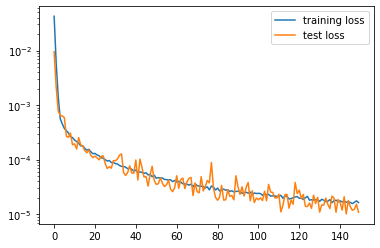

In [14]:
epoch_loss = []
epoch_test_loss = []

model.train()
print(ds.transform)
train_len = len(train_dataloader)
test_len = len(test_dataloader)

all_training_metrics = np.empty((num_epochs, 52, 2))
all_testing_metrics = np.empty((num_epochs, 52, 2))

acc_training = np.zeros((52, 2))
acc_test = np.zeros((52, 2))

for epoch in range(num_epochs):
  current_loss = 0 
  acc_training = np.zeros((52, 2))
  acc_test = np.zeros((52, 2))

  for batch, sample in enumerate(train_dataloader):
    x = sample['x'].to(device)
    y = sample['y'].to(device)

    outputs = model.forward(x) #forward pass

    optimizer.zero_grad() #caluclate the gradient, manually setting to 0

    loss = criterion(outputs, y)
    loss.backward() #calculates the loss of the loss function

    current_loss += loss.item()

    optimizer.step() #improve from loss, i.e backprop

    if epoch % 5 == 0:
      torch.save(model.state_dict(),  save_file_name)
    
    with torch.no_grad():
      getMetrics(acc_training, x, outputs, y, criterion)

  current_test_loss = 0 
  with torch.no_grad():
    for batch, sample in enumerate(test_dataloader):
        x = sample['x'].to(device)
        y = sample['y'].to(device)
        outputs = model.forward(x) #forward pass  
        loss = criterion(outputs, y)
        current_test_loss += loss.item()
        getMetrics(acc_test, x, outputs, y, criterion)

  all_training_metrics[epoch] = acc_training
  all_testing_metrics[epoch] = acc_test

  epoch_test_loss.append(current_test_loss/test_len)

  epoch_loss.append(current_loss/train_len)

  print("Epoch: %d, loss: %1.10f test loss: %1.10f" % (epoch, epoch_loss[-1], epoch_test_loss[-1]))

torch.save(model.state_dict(), save_file_name)

plt.semilogy(epoch_loss, label="training loss")
plt.semilogy(epoch_test_loss, label="test loss")
plt.legend()
plt.show()

### Trained model evaluation

Test trajectories: 2000


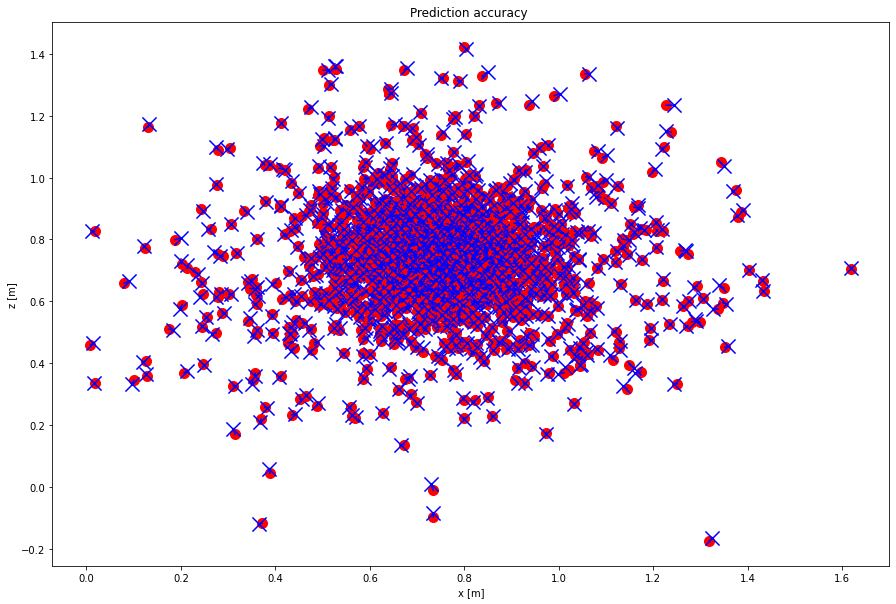

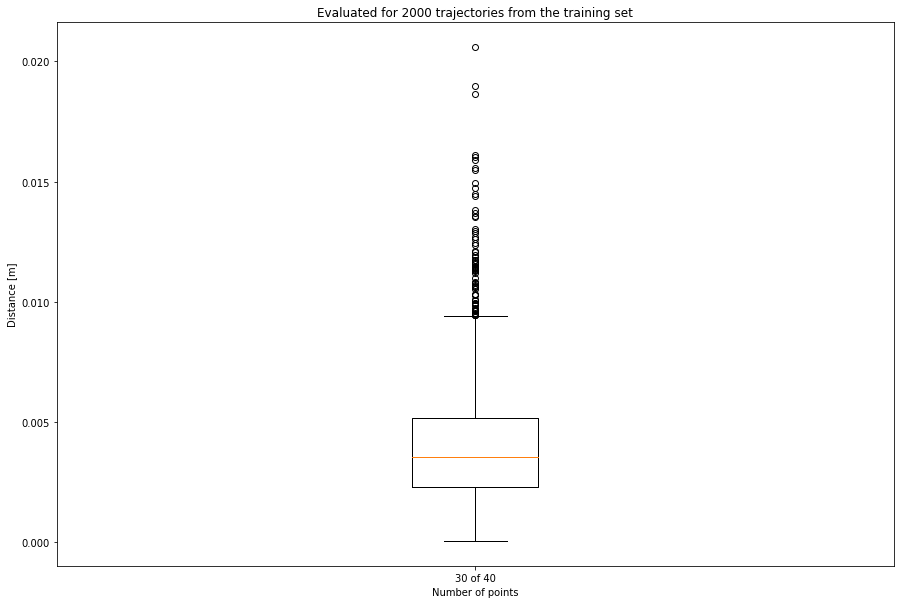

In [15]:
plot_predictions = True 

plt.rcParams["figure.figsize"] = (15,10)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNN4(8, 2)

model.load_state_dict(torch.load(save_file_name, map_location=torch.device('cpu')))
model = model.to(device)
model.eval()

criterion = torch.nn.MSELoss()

datafiles = glob.glob(getFullPath('input_para_2021_03_10_file_*_cut_share.h5'))

ds = MagicDartsDataset(datafiles, noise=False)

test_dataloader = DataLoader(ds, batch_size=1, shuffle=True, num_workers=0)

max_traj = 2000

print("Test trajectories:", max_traj)

max_points = 40
min_valid_points = 30
max_valid_points = 30

distances = np.zeros((max_traj, max_points))
real_distances = np.zeros((max_traj, max_points))

criterion = torch.nn.MSELoss(reduction='mean') 

model.eval()
ix = 0
has_point_plots = False

for sample_index, sample in enumerate(test_dataloader):
  if sample_index == max_traj:
    break
  with torch.no_grad():
    for i in range(min_valid_points-1, max_valid_points):

      cutter = RandomPoints(0, max_time_points=max_points, fixed_points=i+1)
      
      sample['x'] = sample['x'].squeeze()
      sample['y'] = sample['y'].squeeze()

      cut_sample = cutter(sample)

      x_full = cut_sample['x'].to(device).unsqueeze(0)
      y_full = cut_sample['y'].to(device).unsqueeze(0)

      outputs = model.forward(x_full)   
      loss = criterion(outputs, y_full)
      
      npoints = int(max_points - x_full[0, :, 7].sum().item()) 

      hp_x_hat = outputs[0,0].item()
      hp_z_hat = outputs[0,1].item()
      hp_x = y_full[0, 0].item()
      hp_z = y_full[0, 1].item()

      real_distance = np.sqrt((hp_x_hat - hp_x)**2 + (hp_z_hat - hp_z)**2)
      distance = criterion(outputs, y_full)
      distances[sample_index, i] = distance
      real_distances[sample_index, i] = real_distance

      if plot_predictions :
        has_point_plots = True 
        if npoints == max_valid_points:
          plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),c='r', s = 100)
          plt.plot([y_full[0,0], outputs[0, 0]], [y_full[0, 1], outputs[0, 1]], c='b') 
        else:
          plt.scatter(outputs[0, 0].item(), outputs[0, 1].item(),c='g', alpha = npoints/max_valid_points)
        plt.scatter(y_full[0, 0].item(), y_full[0, 1].item(), c='b', marker='x', s=200)

if has_point_plots:
  plt.title(f'Prediction accuracy ')
  plt.xlabel('x [m]')
  plt.ylabel('z [m]')
  plt.show()

plt.title(f"Evaluated for {max_traj} trajectories from the training set")
plt.boxplot(real_distances[:,min_valid_points-1:max_valid_points])
plt.xlabel("Number of points")
plt.ylabel("Distance [m]")
plt.xticks([1], [f"{max_valid_points} of {max_points}"])
plt.show()
